# ELAIS-N1 Luminosity Function

Use the depth maps to get a histogram of areas with a given depth.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-03-27 16:38:39.116452


In [122]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.cosmology import FlatLambdaCDM



import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

from pcigale.sed import SED
from pcigale.sed_modules import get_module

In [3]:
os.environ['GAMA_DATA'] = 'We are not using GAMA data'
from luminosity_function.gal_sample import CosmoLookup

In [3]:
FIELD = 'ELAIS-N1'
FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"
DMU_DIR = '/Users/rs548/GitHub/dmu_products/'

In [5]:
depths = Table.read("{}dmu1/dmu1_ml_ELAIS-N1/data/depths_elais-n1_20180216.fits".format(DMU_DIR))
final_cat = Table.read("{}dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171016.fits".format(DMU_DIR))

## I - Histogram of areas


In [6]:
depths = depths["hp_idx_O_13", 
                "hp_idx_O_10", 
                "ferr_ap_irac_i1_mean", 
                "f_ap_irac_i1_p90", 
                "ferr_irac_i1_mean", 
                "f_irac_i1_p90"]

(0, 5.0)

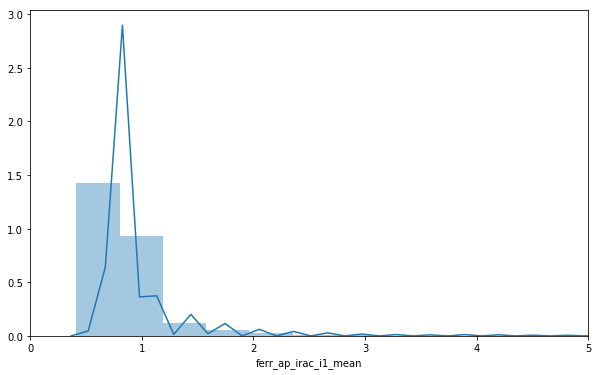

In [7]:
depth_hist_plot = sns.distplot(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])])
depth_hist_plot.set_xlim(0,5.)

In [87]:
bins = np.linspace(0.,2.,1000)
depth_histogram = np.histogram(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])], bins)

NameError: name 'depths' is not defined

In [18]:
np.max(depths["ferr_ap_irac_i1_mean"][~np.isnan(depths["ferr_ap_irac_i1_mean"])])

19.785714285714285

In [19]:
depth_histogram[1][:-1]

array([ 0.        ,  0.002002  ,  0.004004  ,  0.00600601,  0.00800801,
        0.01001001,  0.01201201,  0.01401401,  0.01601602,  0.01801802,
        0.02002002,  0.02202202,  0.02402402,  0.02602603,  0.02802803,
        0.03003003,  0.03203203,  0.03403403,  0.03603604,  0.03803804,
        0.04004004,  0.04204204,  0.04404404,  0.04604605,  0.04804805,
        0.05005005,  0.05205205,  0.05405405,  0.05605606,  0.05805806,
        0.06006006,  0.06206206,  0.06406406,  0.06606607,  0.06806807,
        0.07007007,  0.07207207,  0.07407407,  0.07607608,  0.07807808,
        0.08008008,  0.08208208,  0.08408408,  0.08608609,  0.08808809,
        0.09009009,  0.09209209,  0.09409409,  0.0960961 ,  0.0980981 ,
        0.1001001 ,  0.1021021 ,  0.1041041 ,  0.10610611,  0.10810811,
        0.11011011,  0.11211211,  0.11411411,  0.11611612,  0.11811812,
        0.12012012,  0.12212212,  0.12412412,  0.12612613,  0.12812813,
        0.13013013,  0.13213213,  0.13413413,  0.13613614,  0.13

[<matplotlib.text.Text at 0x12eba3c18>, <matplotlib.text.Text at 0x12eb9e438>]

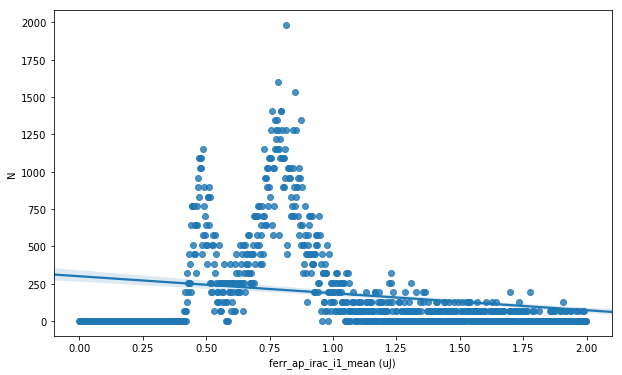

In [20]:
ax = sns.regplot(depth_histogram[1][:-1], depth_histogram[0])
ax.set(xlabel='ferr_ap_irac_i1_mean (uJ)', ylabel='N')

In [69]:
Vmax = Table.read(DMU_DIR + 'dmu28/dmu28_ELAIS-N1/data/zphot/HELP_final_results.fits')#['id']
Vmax['id'].name = 'help_id'
Vmax = Vmax['help_id','UVoptIR_bayes.dust.luminosity', 'UVoptIR_bayes.dust.luminosity_err']

In [70]:
Vmax[:10].show_in_notebook()

idx,help_id,UVoptIR_bayes.dust.luminosity,UVoptIR_bayes.dust.luminosity_err
0,HELP_J155631.108+545024.379,2.19816942179e+36,1.06638524082e+36
1,HELP_J155634.050+545728.087,7.6506379258e+36,1.59701133163e+36
2,HELP_J155635.416+545104.554,3.24456126731e+38,5.49621204007e+37
3,HELP_J155643.789+545434.542,5.32412942465e+37,8.49559512124e+36
4,HELP_J155644.449+545428.304,1.73084126549e+37,5.16574656923e+36
5,HELP_J155645.249+550054.367,2.54553482393e+38,7.15274002342e+37
6,HELP_J155645.430+544835.225,3.06912967609e+38,5.71158661613e+37
7,HELP_J155647.331+550054.897,2.4740858219e+38,7.74362088114e+37
8,HELP_J155647.710+545045.424,5.02726062772e+35,6.1522516509e+34
9,HELP_J155651.625+545843.028,9.67500585184e+37,4.57263773952e+37


## II. First calaculate the irac_i1 flux as a function of redshift for each object

In [71]:
#linearly spaced z - should this be logspace?
redshifts = np.linspace(0, 4, 100)
Vmax.add_column(Column(data=np.full((len(Vmax), len(redshifts)), 
                                    np.full(len(redshifts), np.nan)
                                   ) , 
                       name='f_z_relation'
                      )
               )

In [72]:
Vmax[:10].show_in_notebook()

idx,help_id,UVoptIR_bayes.dust.luminosity,UVoptIR_bayes.dust.luminosity_err,f_z_relation [100]
0,HELP_J155631.108+545024.379,2.19816942179e+36,1.06638524082e+36,nan .. nan
1,HELP_J155634.050+545728.087,7.6506379258e+36,1.59701133163e+36,nan .. nan
2,HELP_J155635.416+545104.554,3.24456126731e+38,5.49621204007e+37,nan .. nan
3,HELP_J155643.789+545434.542,5.32412942465e+37,8.49559512124e+36,nan .. nan
4,HELP_J155644.449+545428.304,1.73084126549e+37,5.16574656923e+36,nan .. nan
5,HELP_J155645.249+550054.367,2.54553482393e+38,7.15274002342e+37,nan .. nan
6,HELP_J155645.430+544835.225,3.06912967609e+38,5.71158661613e+37,nan .. nan
7,HELP_J155647.331+550054.897,2.4740858219e+38,7.74362088114e+37,nan .. nan
8,HELP_J155647.710+545045.424,5.02726062772e+35,6.1522516509e+34,nan .. nan
9,HELP_J155651.625+545843.028,9.67500585184e+37,4.57263773952e+37,nan .. nan


In [81]:
redshifts = np.linspace(0, 4, 100)
n_absent = 0
n_processed = 0

for gal in Vmax['help_id']:

    try:
        orig_spec = Table.read("{}{}{}_best_model.fits".format(DMU_DIR, 
                                              'dmu28/dmu28_ELAIS-N1/data/zphot/best_model_fits/',
                                              gal
                                             ))
        
    except FileNotFoundError:
        n_absent += 1
        # print('fail')
        continue
        
    print('{} no fail'.format(gal))
    s = SED()
    # This is wrong because the best SED we get from CIGALE is redshifted (written by Yannick)
    s.add_contribution("HELP_SED", orig_spec['wavelength'], orig_spec['L_lambda_total'])
    
    fluxes = []
    for r in redshifts:
        sed = s.copy()
        mod = get_module("redshifting", redshift=r)
        mod.process(sed)
        fluxes.append(sed.compute_fnu('IRAC1'))
        
    Vmax['f_z_relation'][Vmax['help_id'] == gal] = fluxes
        
    #print("{}:{}".format(gal,fluxes[0]))
    n_processed +=1

HELP_J155631.108+545024.379 no fail
HELP_J155631.108+545024.379:26736455160167.023
HELP_J155634.050+545728.087 no fail
HELP_J155634.050+545728.087:347584351794500.94
HELP_J155635.416+545104.554 no fail
HELP_J155635.416+545104.554:4.201296978760326e+16
HELP_J155643.789+545434.542 no fail
HELP_J155643.789+545434.542:2193680505302354.8
HELP_J155644.449+545428.304 no fail
HELP_J155644.449+545428.304:3120797095498548.0
HELP_J155645.249+550054.367 no fail
HELP_J155645.249+550054.367:1.8431428163452508e+16
HELP_J155645.430+544835.225 no fail
HELP_J155645.430+544835.225:2.8238965037633976e+16
HELP_J155647.331+550054.897 no fail
HELP_J155647.331+550054.897:1.9581760131308772e+16
HELP_J155647.710+545045.424 no fail
HELP_J155647.710+545045.424:86293069649476.27
HELP_J155651.625+545843.028 no fail
HELP_J155651.625+545843.028:9981802048071528.0
HELP_J155657.720+545649.854 no fail
HELP_J155657.720+545649.854:1280044463063322.8
HELP_J155658.920+545332.279 no fail
HELP_J155658.920+545332.279:248845027

In [74]:
print('{} processed and {} missing'.format(n_processed, n_absent))

21 processed and 50108 missing


## III. Then calculate the zmax for each depth bin for each object

Given the array of fluxes as a function of redhsift we interpolate at the depths based on taking the redshift that the object would have a flux equal to 5$\sigma$ for that mean error bin

In [113]:
#Example object left over as the last object from the previous loop
np.interp(5 * bins *1.e-3, np.flip(fluxes,0), np.flip(redshifts,0))

array([ 4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        3.95340816,  3.89487176,  3.83996551,  3.78576943,  3.73017057,
        3.67633289,  3.6280038 ,  3.58348416,  3.54207735,  3.50341148,
        3.46732335,  3.43203511,  3.39678569,  3.36241245,  3.32884218,
        3.29580083,  3.2633043 ,  3.23159522,  3.20287219,  3.17560341,
        3.14932682,  3.12406088,  3.09915847,  3.07463831,  3.05049882,
        3.02646511,  3.002604  ,  2.97909614,  2.95599059,  2.93432948,
        2.91323324,  2.89350045,  2.87410079,  2.85619779,  2.83887415,
        2.82204109,  2.80597983,  2.78991857,  2.77417171,  2.75847058,
        2.74301141,  2.72811764,  2.71322387,  2.69866831,  2.68

In [88]:
Vmax.add_column(Column(data=np.full((len(Vmax), len(bins)), 
                                    np.full(len(bins), np.nan)
                                   ) , 
                       name='zmax_histogram'
                      )
               )

In [119]:
for gal in Vmax['help_id']:
    fluxes = np.array(Vmax[Vmax['help_id']==gal]['f_z_relation'])[0]
    z_max_f_relation = np.interp(5 * bins *1.e-3, np.flip(fluxes,0), np.flip(redshifts,0))
    Vmax['zmax_histogram'][Vmax['help_id'] == gal] = z_max_f_relation

Lets check the test object above is correct

In [121]:
np.array(Vmax[Vmax['help_id']=='HELP_J155700.909+550039.328']['zmax_histogram'])[0]

array([ 4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        4.        ,  4.        ,  4.        ,  4.        ,  4.        ,
        3.95340816,  3.89487176,  3.83996551,  3.78576943,  3.73017057,
        3.67633289,  3.6280038 ,  3.58348416,  3.54207735,  3.50341148,
        3.46732335,  3.43203511,  3.39678569,  3.36241245,  3.32884218,
        3.29580083,  3.2633043 ,  3.23159522,  3.20287219,  3.17560341,
        3.14932682,  3.12406088,  3.09915847,  3.07463831,  3.05049882,
        3.02646511,  3.002604  ,  2.97909614,  2.95599059,  2.93432948,
        2.91323324,  2.89350045,  2.87410079,  2.85619779,  2.83887415,
        2.82204109,  2.80597983,  2.78991857,  2.77417171,  2.75847058,
        2.74301141,  2.72811764,  2.71322387,  2.69866831,  2.68

## IV. Finally calculate the Vmax on EN1 for each object
For every object calculate the Vmax for each depth cell and multiply by the number of cells at that depth

In [123]:
Vmax.add_column(Column(data=np.full((len(Vmax), len(bins)), 
                                    np.full(len(bins), np.nan)
                                   ) , 
                       name='vmax_histogram'
                      )
               )

In [124]:
cosmo = FlatLambdaCDM(H0=100. , Om0 = (1-0.7))


In [125]:
for gal in Vmax['help_id']:
    
    z_max_f_relation = np.array(Vmax[Vmax['help_id']==gal]['zmax_histogram'])[0]
    v_max_f_relation = cosmo.comoving_volume(z_max_f_relation)
    

KeyboardInterrupt: 

In [126]:
v_max_f_relation.value()

<Quantity [ nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
            nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
def gal_sample(z0,z1,Ldust,Vmax):
    